# Семантическая сегментация (Semantic Segmentation)

Решаем задачу классификации для каждого пикселя изображения: предсказываем семантический класс (например, человек, автомобиль, дерево, небо). Это более сложная задача, чем классификация изображений, которая предсказывает единственную метку для всего изображения.

* <span style="color:green">относительно быстро/легко</span>
* <span style="color:green">"попиксельное" предсказание</span>
* <span style="color:red">не различает отдельные объекты (instances)</span>

![segmentation_intro](https://drive.google.com/uc?export=view&id=1QHKcKkuS4ZXYledI_OUcQsD6jXoFuDLN)

# Решаем Semantic Segmentation

* за основу решения возьмем архитектуру типа "encoder-decoder"
* **encoder:** сжимает входные данные в латентное представление `z = f(x)`
* **decoder:** делает прогноз на основе латентного представления `y = g(z)`

![segmentation_transfer_learning](https://drive.google.com/uc?export=view&id=10OwVDRgSArZOQJatE2Fs0Yfm4XYbw1KP)

In [ ]:
!pip install torch torchvision kornia opencv-python matplotlib albumentations pytorch-lightning wldhx.yadisk-direct --quiet

In [ ]:
import os
import torchvision
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import cv2

os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [ ]:
url = 'https://drive.google.com/uc?export=view&id=1NqtSH55syYeb8IWBVVGgW1qBbjhZk5MD'
img_pil = Image.open(requests.get(url, stream=True).raw)
img_np = np.asarray(img_pil)

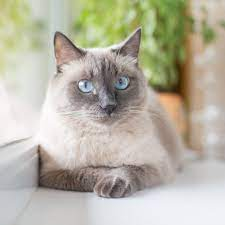

In [ ]:
img_pil

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
img = to_tensor(img_pil)

In [ ]:
def plot_img_tensor(img: torch.Tensor, dpi=80):
    _, height, width = img.shape
    figsize = width / float(dpi), height / float(dpi)
    plt.figure(figsize=figsize)
    plt.imshow(img.detach().cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.show()

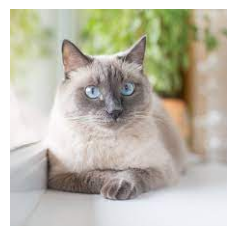

In [ ]:
plot_img_tensor(img)

Вспоминаем, как работает nn.Conv2d, nn.MaxPool2d, nn.AvgPool2d

In [ ]:
x = torch.randn(2, 3, 700, 700) # (батч, число каналов, высота, ширина)
kernel_size = 3
padding = kernel_size // 2
module = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(kernel_size, kernel_size), stride=1, padding=0)
print(module(x).shape) # (батч, число каналов, высота, ширина)

torch.Size([2, 64, 698, 698])


input shape torch.Size([1, 3, 225, 225])
output shape torch.Size([1, 3, 112, 112])


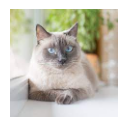

In [ ]:
import torch.nn.functional as F

# вариант 1, запускаем пулинг как nn.Module
module = nn.AvgPool2d((2, 2), (2, 2))
y = module(img[None])
print('input shape', img[None].shape) # [None] добавляет дополнительную размерность в начале
print('output shape', y.shape)

plot_img_tensor(y[0])

input shape torch.Size([1, 3, 225, 225])
output shape torch.Size([1, 3, 112, 112])


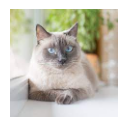

In [ ]:
# вариант 2 - запускаем пулинг как функциию

y = F.avg_pool2d(img[None], (2, 2), (2, 2))
print('input shape', img[None].shape) # [None] добавляет дополнительную размерность в начале
print('output shape', y.shape)

plot_img_tensor(y[0])

### Nearest upsampling

Далее, когда будем реализовывать декодер, о нем подробнее позже, нам понадобится увеличивать по ширине/высоте картинку или в общем случае тензор признаков. Есть два популярных базовых способ - nearest и билинейная интерполяция.

In [ ]:
x = torch.randn(1, 1, 3, 3)
print(x)
print(F.interpolate(x, size=(6, 6), mode='nearest'))

tensor([[[[ 0.7833,  0.1762, -0.7147],
          [-1.8044, -0.5173,  0.1410],
          [ 0.0886,  0.6089,  0.6195]]]])
tensor([[[[ 0.7833,  0.7833,  0.1762,  0.1762, -0.7147, -0.7147],
          [ 0.7833,  0.7833,  0.1762,  0.1762, -0.7147, -0.7147],
          [-1.8044, -1.8044, -0.5173, -0.5173,  0.1410,  0.1410],
          [-1.8044, -1.8044, -0.5173, -0.5173,  0.1410,  0.1410],
          [ 0.0886,  0.0886,  0.6089,  0.6089,  0.6195,  0.6195],
          [ 0.0886,  0.0886,  0.6089,  0.6089,  0.6195,  0.6195]]]])


input shape torch.Size([1, 3, 225, 225])
output shape torch.Size([1, 3, 450, 450])


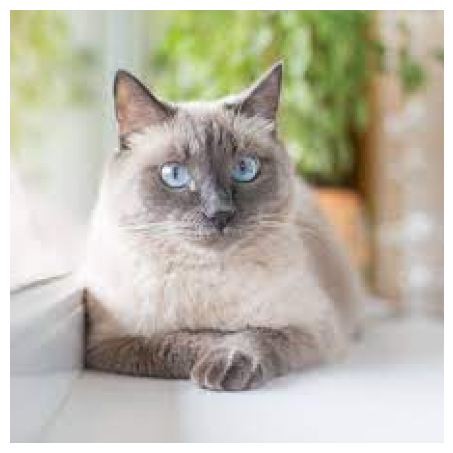

In [ ]:
upsampled_image = F.interpolate(img[None], size=(450, 450), mode='nearest')
print('input shape', img[None].shape)
print('output shape', upsampled_image.shape)
plot_img_tensor(upsampled_image[0])

input shape torch.Size([1, 3, 225, 225])
output shape torch.Size([1, 3, 450, 450])


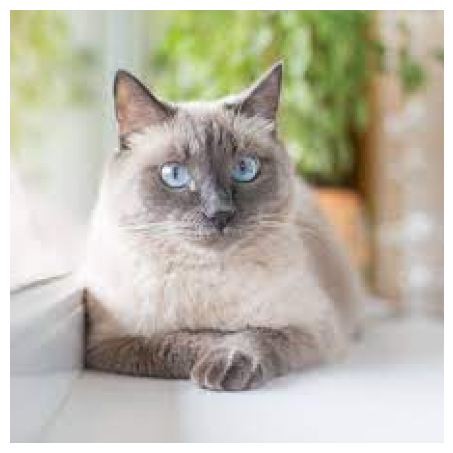

In [ ]:
# также можно указывать не конечный size, а scale_factor - во сколько раз изменить размеры картинки
upsampled_image = F.interpolate(img[None], scale_factor=2.0, mode='nearest')
print('input shape', img[None].shape)
print('output shape', upsampled_image.shape)
plot_img_tensor(upsampled_image[0])

### Bilinear upsampling

Если хотим более гладкую интерполяцию, можно использовать билинейную интерполяцию. При этом она по скорости медленнее чем nearest интерполяция

In [ ]:
x = torch.randn(1, 1, 3, 3)
print(x)
print(F.interpolate(x, size=(6, 6), mode='bilinear'))

tensor([[[[ 1.0432, -0.3424, -1.0481],
          [ 0.7029, -0.0262, -0.2027],
          [ 0.6925, -1.3723,  0.1945]]]])
tensor([[[[ 1.0432,  0.6968,  0.0040, -0.5188, -0.8717, -1.0481],
          [ 0.9581,  0.6527,  0.0420, -0.4067, -0.6934, -0.8368],
          [ 0.7879,  0.5646,  0.1180, -0.1825, -0.3369, -0.4141],
          [ 0.7003,  0.4345, -0.0970, -0.2979, -0.1682, -0.1034],
          [ 0.6951,  0.2623, -0.6031, -0.7531, -0.1875,  0.0952],
          [ 0.6925,  0.1763, -0.8561, -0.9806, -0.1972,  0.1945]]]])


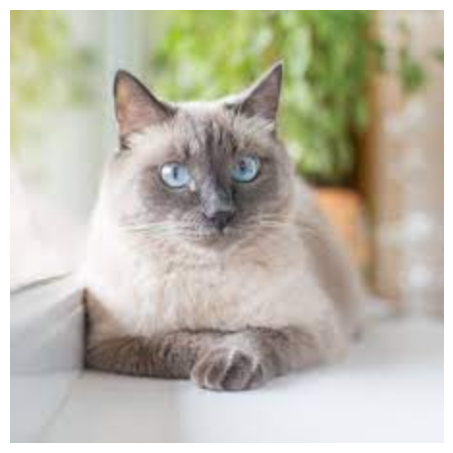

In [ ]:
upsampled_image = F.interpolate(img[None], scale_factor=2.0, mode='bilinear')
plot_img_tensor(upsampled_image[0])

# Извлекаем карты признаков из классификационной сети

Большинство сетей для сегментации состоят из энкодера и декодера.

Енкодер - та часть, что будет кодировать/сжимать картинку, чтобы получить "высокоуровневые" признаки для последующей работы.

Декодер - та часть, что будет "раскодировать"/увеличивать сжатое представление до исходных размеров картинки, чтобы каждому пикселю соответствовал свой набор признаков для последующей попиксельной классификации (семантической сегментации).



Стоит отметить, что классификационная сеть = энкодер + классификационная голова.

Воспользуемся енкодером из любой классификационной сети для извлечения карты признаков.

In [ ]:
model = torchvision.models.resnet50()

Посмотрим из чего состоит модель

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

По умолчанию модель классификационная модель выдает логиты, которые далее отдельно можно подать на вход softmax, чтобы получить вероятности.

По умолчанию модели из torchvision делают классификацию на 1000 классов ImageNet.

In [ ]:
model(img[None]).shape

torch.Size([1, 1000])

Нам необходимо избавиться от классификационной головы. Для этого заменим последний линейный слой на Identity слой, который не меняет никак входной объект. Нужное название линейного слоя можно поискать в определении модели.

In [ ]:
print([n for n, m in model.named_modules() if type(m) == nn.Linear])

['fc']


In [ ]:
model.fc = nn.Identity() # nn.Identity()(x) == x

In [ ]:
model(img[None]).shape

torch.Size([1, 2048])

Теперь модель выдает эмбеддинг, вектор описывающий картинку. Видим также размер, в случае resnet50 эмбеддинг имеет размер 2048. Этот вектор получен путем усреднения всех пикселей. Как получить карту признаков до усреднения пикселей в один эмбеддинг?

Самый удобный и простой способ для этих целей - воспользоваться отдельной популярной библиотекой timm! Внутри нее вшит нужный нам функционал.

In [ ]:
%pip install timm --quiet
import timm

In [ ]:
model = timm.create_model('resnet50', pretrained=True)
o = model(torch.randn(2, 3, 224, 224))
print(f'Original shape: {o.shape}')

# Путем добавления дополнительный аргументов можно удалить
# финальный пулинг и классификационную голову
model = timm.create_model('resnet50', pretrained=True, num_classes=0, global_pool='')
o = model(torch.randn(2, 3, 224, 224))
print(f'Unpooled shape: {o.shape}')
o = model(torch.randn(2, 3, 500, 500))
print(f'Unpooled shape: {o.shape}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Original shape: torch.Size([2, 1000])
Unpooled shape: torch.Size([2, 2048, 7, 7])
Unpooled shape: torch.Size([2, 2048, 16, 16])


Таким образом мы научились извлекать энкодер часть из классификационной сети, которая позволяет извлекать "картинку"/тензор признаков с последнего сверточного блока. Подобный энкодер также часто носит название backbone.

# UNET with ResNet18 backbone (2015)
![segmentation_unet](https://drive.google.com/uc?export=view&id=1gDfKbzpH9JiTI7K6oRIARP8SDJnTZhfn)

Также можно извлекать набор карт признаков из энкодера:

In [ ]:
import torch
import timm
m = timm.create_model('resnet18', features_only=True, pretrained=True)
o = m(torch.randn(2, 3, 224, 608))
for x in o:
    print(x.shape)

torch.Size([2, 64, 112, 304])
torch.Size([2, 64, 56, 152])
torch.Size([2, 128, 28, 76])
torch.Size([2, 256, 14, 38])
torch.Size([2, 512, 7, 19])


In [ ]:
class UNET(nn.Module):

    def __init__(self, n_classes, last_act='', pretrained=True):
        super().__init__()

        # в init определяются подмодули и буфферы
        self.encoder = timm.create_model('resnet18', features_only=True, pretrained=pretrained)
        self.decoder_conv1 = nn.Conv2d(768, 256, (3, 3), padding=1)
        self.decoder_conv2 = nn.Conv2d(384, 128, (3, 3), padding=1)
        self.decoder_conv3 = nn.Conv2d(192, 64, (3, 3), padding=1)
        self.decoder_conv4 = nn.Conv2d(128, 64, (3, 3), padding=1)

        # kernel_size = (1, 1) превращает Conv2d слой по сути в Linear слой,
        # который обрабатывает каждый пиксель в отдельности
        self.final = nn.Conv2d(64, n_classes, (1, 1), padding=0)

        self.last_act = None
        if last_act == 'sigmoid':
            # binary or multilabel classification
            self.last_act = nn.Sigmoid()
        elif last_act == 'softmax':
            # multiclass classification
            self.last_act = nn.Softmax()
        else:
            # logits
            assert last_act == ''

        cfg = self.encoder.pretrained_cfg if pretrained else self.encoder.default_cfg
        self.register_buffer('mean', torch.tensor(cfg['mean']).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor(cfg['std']).view(1, 3, 1, 1))

    def forward(self, x):
        """
        Args:
            x (Tensor): of shape (b, 3, H, W)
        Returns:
            Tensor of shape (b, n_classes, H, W)
            that containes either logits or probs (depends on final_act)
        """
        b, _3, H, W = x.shape

        x = (x - self.mean) / self.std

        h1, h2, h3, h4, h5 = self.encoder(x)

        out = torch.concatenate([h4, F.interpolate(h5, size=h4.shape[-2:], mode='bilinear')], dim=1)
        out = F.relu(self.decoder_conv1(out))
        out = torch.concatenate([h3, F.interpolate(out, size=h3.shape[-2:], mode='bilinear')], dim=1)
        out = F.relu(self.decoder_conv2(out))
        out = torch.concatenate([h2, F.interpolate(out, size=h2.shape[-2:], mode='bilinear')], dim=1)
        out = F.relu(self.decoder_conv3(out))
        out = torch.concatenate([h1, F.interpolate(out, size=h1.shape[-2:], mode='bilinear')], dim=1)
        out = F.relu(self.decoder_conv4(out))

        out = F.interpolate(out, size=(H, W), mode='bilinear') # (b, 64, H, W)
        out = self.final(out) # (b, n_classes, H, W)

        if self.last_act is not None:
            out = self.last_act(out)

        return out

In [ ]:
model = UNET(n_classes=2)
for h, w in [(100, 200), (300, 300), (450, 300)]:
    x = torch.rand(1, 3, h, w)
    print('output shape:', model(x).shape)

output shape: torch.Size([1, 2, 100, 200])
output shape: torch.Size([1, 2, 300, 300])
output shape: torch.Size([1, 2, 450, 300])


![segmentation_transfer_learning](https://drive.google.com/uc?export=view&id=1LWFBMmf1274OlhZwizzloTEoelPX12wV)

In [ ]:
def dice_score(output, target, eps=1e-7):
  """
  Args:
    output (Tensor): of shape (b, n_classes, h, w)
    target (Tensor): of shape (b, n_classes, h, w)
  """
  b, n_classes, h, w = output.shape
  dice_score = (2.0 * torch.sum(output * target)) / (torch.sum(output + target) * b * n_classes).clamp_min(eps)
  return dice_score

def dice_loss(output, target):
  return 1 - dice_score(output, target)

# Полный pipeline

## Грузим данные

Воспользуемся датасетом [**CamVid**](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/). Он состоит из:
 - **train** картинки + сегментационные маски
 - **val** картинки + сегментационные маски
 - **test** картинки + сегментационные маски

Все картинки размером 320x480 пикселей.

In [ ]:
DATA_DIR = './CamVid/'

!curl -L $(yadisk-direct https://disk.yandex.ru/d/pJSWfZB975SC4Q) -o CamVid.zip
!unzip -o -qq CamVid.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  178M  100  178M    0     0  13.2M      0  0:00:13  0:00:13 --:--:-- 17.1M


In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap="gray")
    plt.show()

### Dataloader

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
class CamVidDataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. normalization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

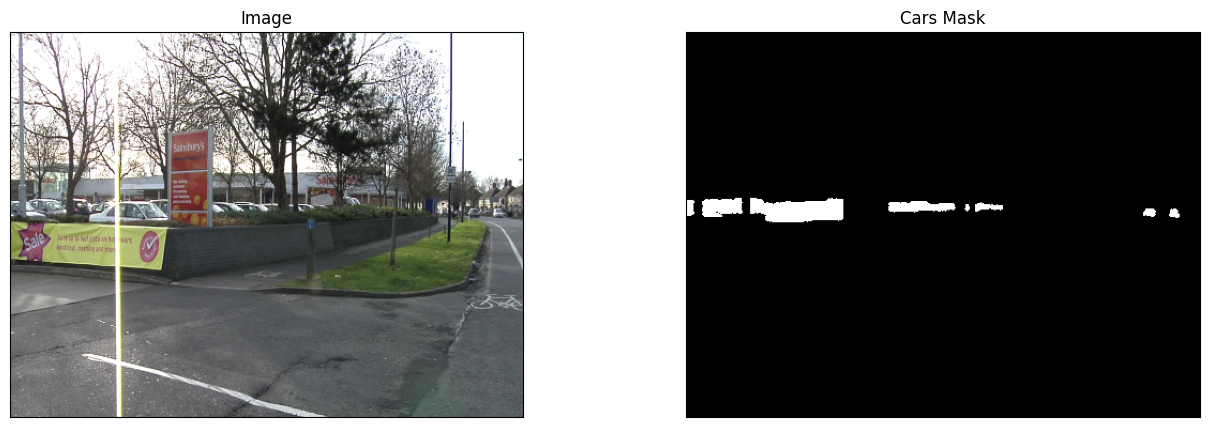

In [ ]:
# Lets look at data we have

dataset = CamVidDataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
visualize(
    image=image,
    cars_mask=mask.squeeze(),
)

### Аугментации

Воспользуемся библиотекой [**Albumentations**](https://github.com/albu/albumentations/).

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1, contrast_limit=0.0),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1, brightness_limit=0.0),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

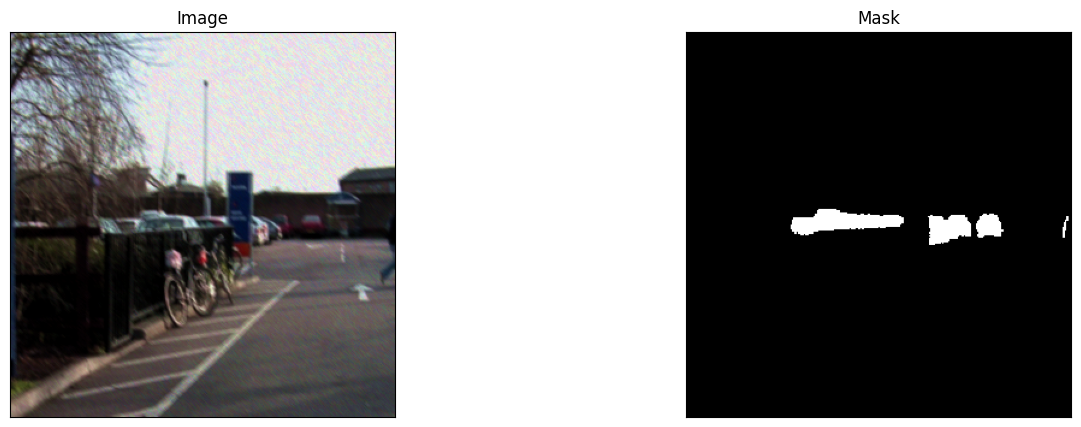

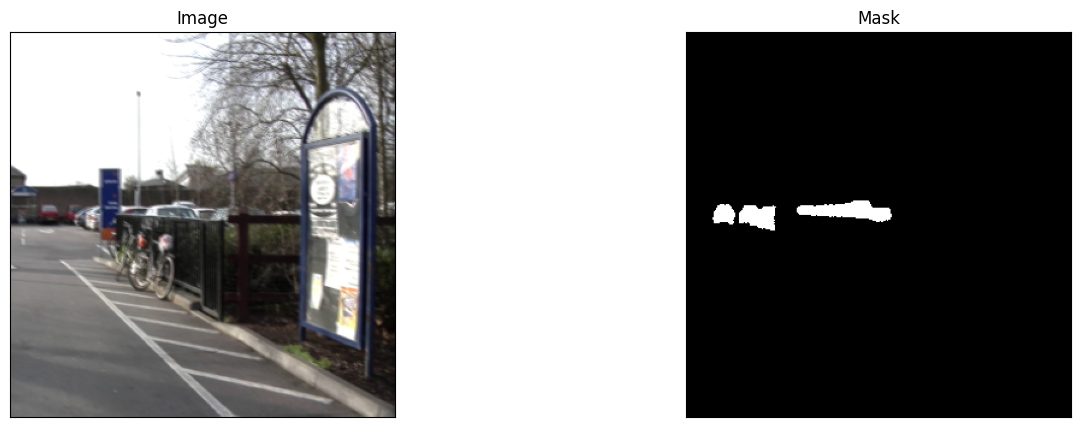

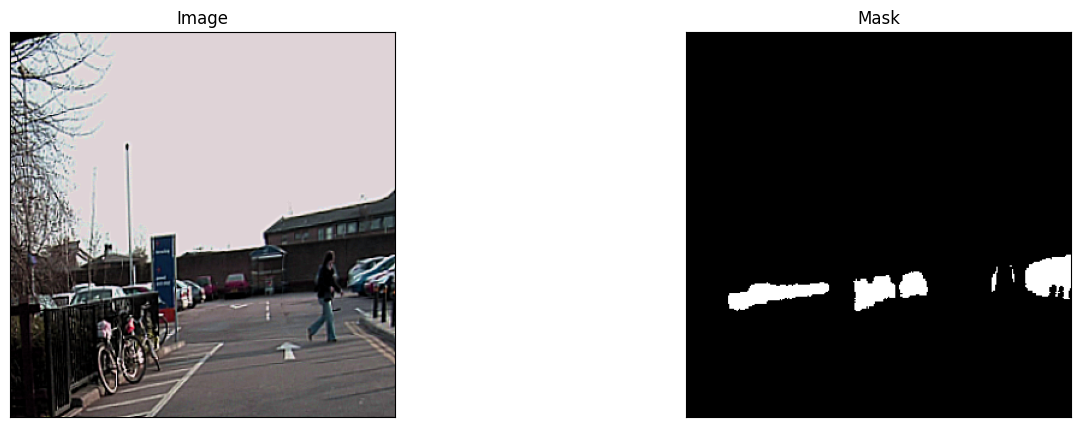

In [ ]:
#### Визуализируем аугментированные картинки и маски

augmented_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=['car'],
)

for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Обучаем и тестируем модель

In [ ]:
import pytorch_lightning as pl
import torchmetrics as tm

In [ ]:
class SegModel(pl.LightningModule):

    def __init__(self, data_dir):
        super().__init__()

        classes = ['car']

        def div_by_255(img, **kwargs):
            return img / 255.
        preprocessing_fn = div_by_255

        self.model = UNET(n_classes=1, last_act='sigmoid')

        self.train_dataset = CamVidDataset(
            os.path.join(data_dir, 'train'),
            os.path.join(data_dir, 'trainannot'),
            augmentation=get_training_augmentation(),
            preprocessing=get_preprocessing(preprocessing_fn),
            classes=classes,
        )

        self.val_dataset = CamVidDataset(
            os.path.join(data_dir, 'val'),
            os.path.join(data_dir, 'valannot'),
            augmentation=get_validation_augmentation(),
            preprocessing=get_preprocessing(preprocessing_fn),
            classes=classes,
        )

        self.test_dataset = CamVidDataset(
            os.path.join(data_dir, 'test'),
            os.path.join(data_dir, 'testannot'),
            augmentation=get_validation_augmentation(),
            preprocessing=get_preprocessing(preprocessing_fn),
            classes=classes,
        )

        self.iou = {
          'val': tm.classification.BinaryJaccardIndex(),
          'test': tm.classification.BinaryJaccardIndex(),
        }

    def forward(self, x):
      return self.model(x)

    def training_step(self, batch, batch_nb):
      img, mask = batch
      out = self(img)
      loss = dice_loss(out, mask)
      return loss

    def eval_step(self, batch, batch_idx, stage):
        img, mask = batch
        out = self(img)
        self.iou[stage].update(out.cpu(), mask.long().cpu())

    def on_eval_epoch_end(self, stage, **kwargs):
        self.log(f"IOU/{stage}", self.iou[stage].compute(), prog_bar=True, logger=True)
        self.iou[stage].reset()

    def validation_step(self, batch, batch_idx):
        self.eval_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        self.eval_step(batch, batch_idx, 'test')

    def on_validation_epoch_end(self, **kwargs):
        self.on_eval_epoch_end('val', **kwargs)

    def on_test_epoch_end(self, **kwargs):
        self.on_eval_epoch_end('test', **kwargs)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=0.001)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=32, num_workers=os.cpu_count(), shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=8, num_workers=os.cpu_count(), shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=8, num_workers=os.cpu_count(), shuffle=False)

In [ ]:
pl.seed_everything(123)
seg_model = SegModel(DATA_DIR)
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='checkpoints', monitor="IOU/val", mode="max")

trainer = pl.Trainer(callbacks=[checkpoint_callback],
                     accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                     devices=1, max_epochs=70,
                     num_sanity_val_steps=0, log_every_n_steps=10)

INFO:lightning_fabric.utilities.seed:Seed set to 123
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(seg_model)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | UNET | 13.6 M
-------------------------------
13.6 M    Trainable params
0         Non-trainable params
13.6 M    Total params
54.293    Total estimated model params size (MB)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=70` reached.


In [ ]:
trainer.test(ckpt_path='best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/epoch=65-step=792.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/epoch=65-step=792.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         IOU/test          │    0.6892069578170776     │
└───────────────────────────┴───────────────────────────┘

[{'IOU/test': 0.6892069578170776}]

## Визаулизируем предсказания

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = CamVidDataset(
    x_test_dir, y_test_dir,
    classes=['car'],
)

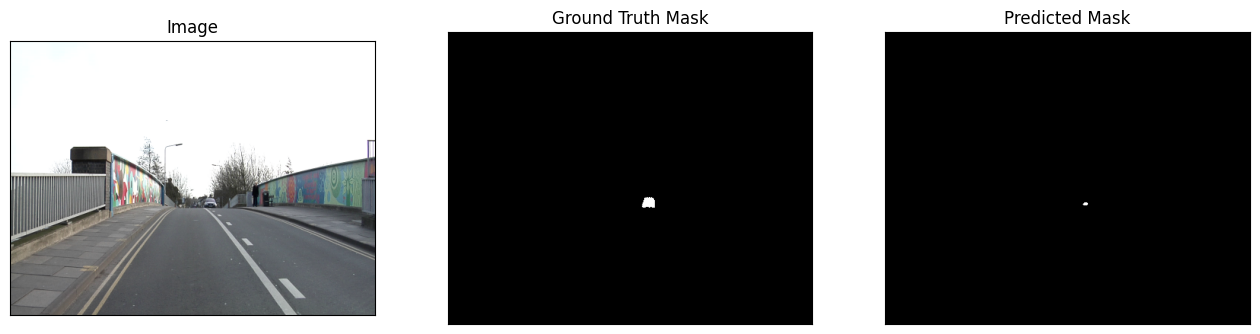

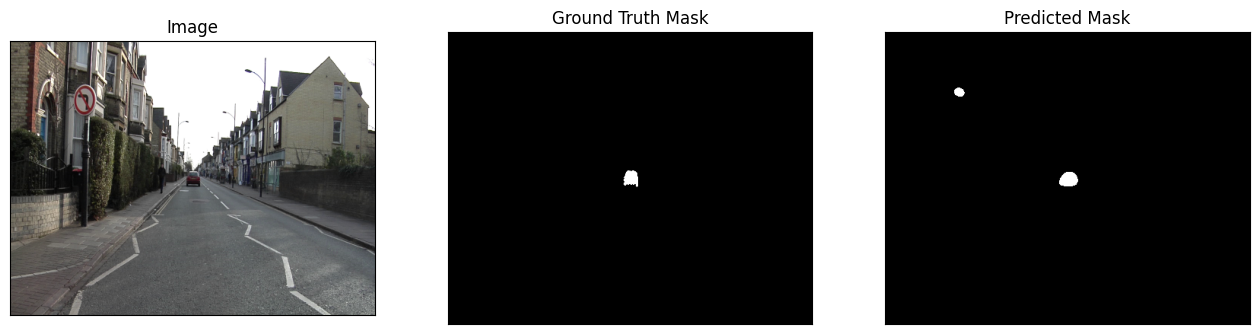

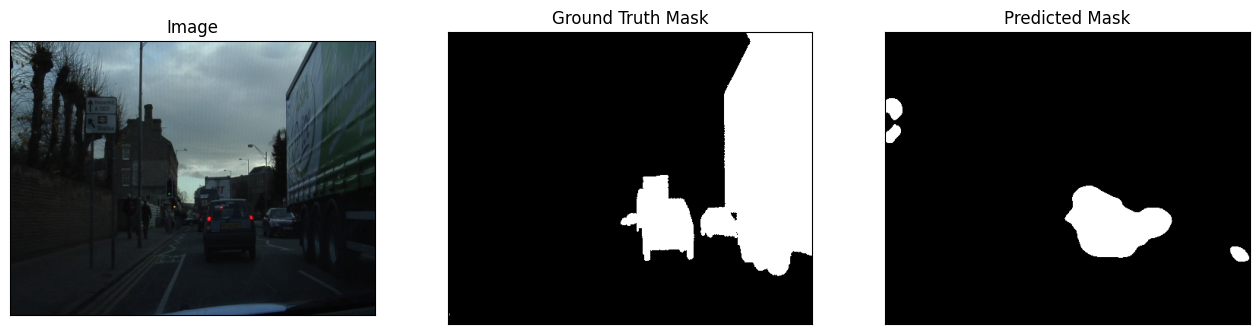

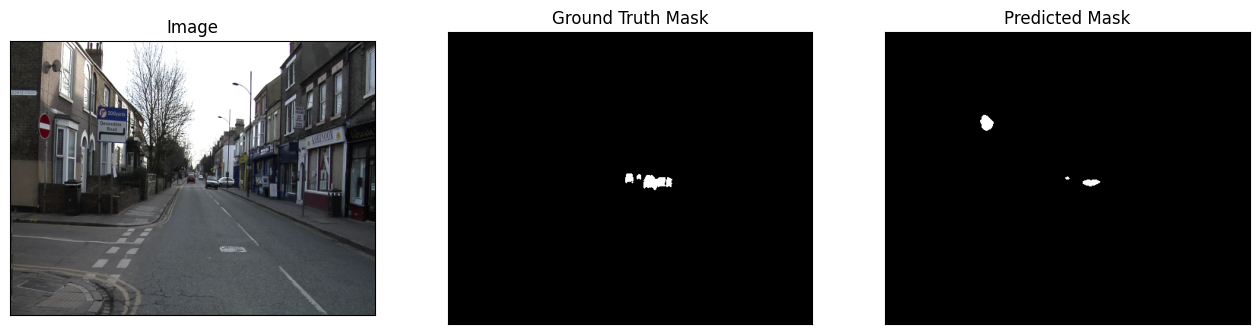

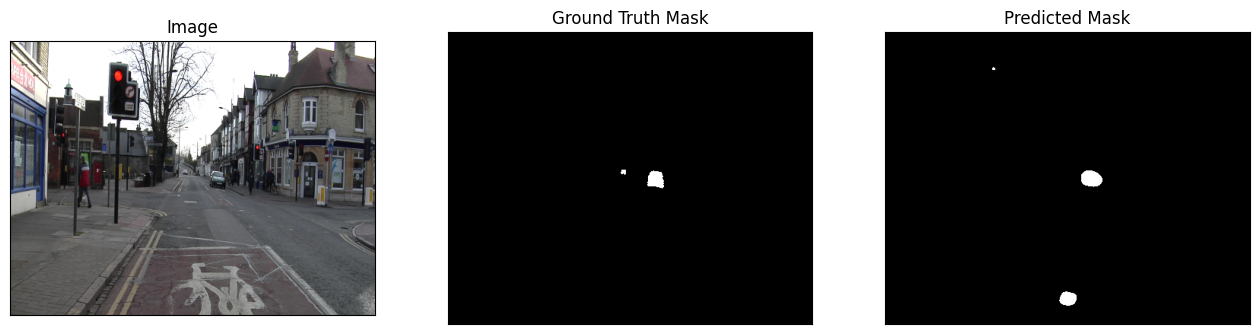

In [ ]:
seg_model.eval()

for i in range(5):
    n = np.random.choice(len(seg_model.test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = seg_model.test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = seg_model(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round())

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask,
        predicted_mask=pr_mask
    )

# Отвечаем на вопрос "где"?

![segmetation_kinds](https://drive.google.com/uc?export=view&id=1dfLTkIgB0PffBSlGOgvc8flXw_2uB8EC)
![segmetation_od](https://drive.google.com/uc?export=view&id=18VJBuoynt-zTWejVYSNhFNCKm3X3lwXL)

#### Semantic segmentation

Решаем задачу классификации для каждого пикселя изображения: предсказываем семантический класс (например, человек, автомобиль, дерево, небо). Это более сложная задача, чем классификация изображений, которая предсказывает единственную метку для всего изображения.

* <span style="color:green">относительно быстро/легко</span>
* <span style="color:green">"попиксельное" предсказание</span>
* <span style="color:red">не различает отдельные объекты (instances)</span>

#### Object Detection

* <span style="color:green">относительно быстро/легко</span>
* <span style="color:green">различает отдельные объекты (instances)</span>
* <span style="color:red">грубое предсказание</span>

#### Instance segmentation

Решаем задачу обнаружения каждого интересующего объекта на изображении (например, отдельные люди)

* <span style="color:green">"попиксельное" предсказание</span>
* <span style="color:green">различает отдельные объекты (instances)</span>
* <span style="color:red">медленно/сложно</span>

#### Panopic segmentation = Semantic + Instance